In [ ]:
import nibabel as nib
import numpy as np
import os

all_data = []
flat_data = []
ages = []
sexes = []
non_zeros = np.load('non_zeros.npy')
fails = 0
rootDir = 'data'
for dirName, subdirList, fileList in os.walk(rootDir):
    if 'T88' in dirName and 't4_files' not in dirName: 
        ds = dirName.split('/')
        sessionId = ds[2]
        metadataFileName = '/'.join(ds[0:3]) + '/' + sessionId + '.txt'
        dataFileName = '/'.join(ds) + '/' + sessionId + '_mpr_n4_anon_111_t88_masked_gfc.img'
        try:
            img = nib.load(dataFileName)
        except FileNotFoundError:
            dataFileName = '/'.join(ds) + '/' + sessionId + '_mpr_n3_anon_111_t88_masked_gfc.img'
        try:
            img = nib.load(dataFileName)
        except FileNotFoundError:
            fails += 1
            continue
        data = img.get_data()
        # all_data.append(data)
        with open(metadataFileName) as f:
            for line in f:
                if "AGE:" in line:
                    ages.append(list(filter(None, line.split()))[1])
                elif "M/F:" in line:
                    sexes.append(list(filter(None, line.split()))[1])
                    break
        
        # creating the non_zero array of indexes 
        # inds = np.where(data.flatten() > 0)
        # if non_zeros.size == 0: 
        #    non_zeros = inds[0]
        # else: 
        #    non_zeros = np.intersect1d(non_zeros, inds[0])
        
        flat_data.append(data.flatten()[non_zeros])
        
        
# all_data = np.asarray(all_data, float)
flat_data_np = np.array(flat_data)

# WARNING: UNCOMMENTING THE FOLLOWING LINES WILL OVERWRITE YOUR BACKUPS

# np.save('flat_data', flat_data_np)
# np.save('ages', ages)
# np.save('sexes', sexes)

In [12]:
import numpy as np

ages = np.load('ages.npy')
#sexes = np.load('sexes.npy')
flat_data_np = np.load('flat_data.npy', dtype='float32')

TypeError: load() got an unexpected keyword argument 'dtype'

In [2]:
# finding items, that are equal everywhere
notTheSame = np.where(np.not_equal(flat_data_np[0], flat_data_np[1]))[0]
for element in flat_data_np:
    inds = np.where(np.not_equal(flat_data_np[0], flat_data_np[1]))[0]
    notTheSame = np.intersect1d(notTheSame, inds)
    
flat_data_filtered = flat_data_np[:,notTheSame]
flat_data_np = None
notTheSame = None # freeing up some memory
flat_data_filtered.shape

(434, 1658718)

In [14]:
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt


pca = IncrementalPCA(batch_size=105, n_components=20)
model = pca.fit(flat_data_filtered, ages)

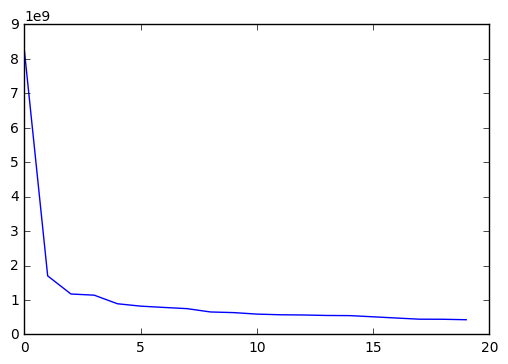

In [15]:
%matplotlib inline

plt.plot(model.explained_variance_)

In [16]:
transformedData = model.transform(flat_data_filtered, ages)

In [68]:
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(transformedData, ages, test_size=0.2)

mod = rfr(n_estimators=75)
mod.fit(X_train, y_train)
y_out = np.array(mod.predict(X_test))
y_test = np.array(y_test, dtype='float64')
res = abs(y_out - y_test)
np.mean(res)

7.2521072796934876

In [7]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.17.1.
